# Cell 1 - Title and Description

# Seasonal LSTM Models for Wind Speed Forecasting
## Four Independent Models for Spring, Summer, Autumn, and Winter

# This notebook implements separate LSTM models for each season to forecast wind speeds.
## Dataset: Hourly wind speeds from 2001-2002
## Goal: Forecast each season of 2003

# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Preprocessing and Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Cell 3 - Load and Prepare Data """# Load and Process Initial Data"""

In [2]:
# Load data
df = pd.read_csv(r"C:\Users\hp\Cyprus_Researh\wind2001_2002.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Add time features
df['year'] = df.index.year
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day'] = df.index.day

# Define seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:  # months 12, 1, 2
        return 'Winter'

df['season'] = df['month'].apply(get_season)

# Add these features to your data preparation
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df['day_sin'] = np.sin(2 * np.pi * df.index.day / 31)
df['day_cos'] = np.cos(2 * np.pi * df.index.day / 31)

df

,Wind (m/s 10 m),d1,d2,d3,year,month,hour,day,season,hour_sin,hour_cos,day_sin,day_cos
Timestamp,,,,,,,,,,,,,
2001-01-01 00:00:00,9.86,0.635,-0.6925,-0.78500,2001,1,0,1,Winter,0.000000,1.000000,2.012985e-01,0.97953
2001-01-01 01:00:00,8.59,-0.635,-0.6925,-0.78500,2001,1,1,1,Winter,0.258819,0.965926,2.012985e-01,0.97953
2001-01-01 02:00:00,9.93,-0.680,0.6925,-0.78500,2001,1,2,1,Winter,0.500000,0.866025,2.012985e-01,0.97953
2001-01-01 03:00:00,11.29,0.680,0.6925,-0.78500,2001,1,3,1,Winter,0.707107,0.707107,2.012985e-01,0.97953
2001-01-01 04:00:00,10.79,-0.465,-0.2325,0.78500,2001,1,4,1,Winter,0.866025,0.500000,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 19:00:00,5.01,0.060,0.2475,-1.38125,2002,12,19,31,Winter,-0.965926,0.258819,-2.449294e-16,1.00000
2002-12-31 20:00:00,7.28,0.310,-0.7150,1.38125,2002,12,20,31,Winter,-0.866025,0.500000,-2.449294e-16,1.00000
2002-12-31 21:00:00,8.16,-0.310,-0.7150,1.38125,2002,12,21,31,Winter,-0.707107,0.707107,-2.449294e-16,1.00000


# Cell 4 - Split Data by Season """# Create Seasonal Datasets"""

In [3]:
# Create separate dataframes for each season
seasonal_dfs = {}
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    seasonal_dfs[season] = df[df['season'] == season].copy()
    print(f"{season} shape: {seasonal_dfs[season].shape}")
    print(f"Date range: {seasonal_dfs[season].index.min()} to {seasonal_dfs[season].index.max()}\n")

Spring shape: (4416, 13)
Date range: 2001-03-01 00:00:00 to 2002-05-31 23:00:00

Summer shape: (4416, 13)
Date range: 2001-06-01 00:00:00 to 2002-08-31 23:00:00

Autumn shape: (4368, 13)
Date range: 2001-09-01 00:00:00 to 2002-11-30 23:00:00

Winter shape: (4320, 13)
Date range: 2001-01-01 00:00:00 to 2002-12-31 23:00:00



# Cell 5 - Prepare Sequences Function """# Define Data Preparation Functions"""

In [4]:
def create_sequences(data, seq_length=24):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def prepare_seasonal_data(season_df, seq_length=24):
    """Prepare data for one season"""
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(season_df[['Wind (m/s 10 m)']])
    
    # Split by year
    data_2001 = scaled_data[season_df.index.year == 2001]
    data_2002 = scaled_data[season_df.index.year == 2002]
    
    # Create sequences
    X_train, y_train = create_sequences(data_2001, seq_length)
    X_val, y_val = create_sequences(data_2002, seq_length)
    
    return X_train, y_train, X_val, y_val, scaler

# Cell 6 - Build LSTM Model Function """# Define Model Building Function"""

In [5]:
def build_seasonal_lstm(seq_length=24, features=1):
    model = Sequential([
        LSTM(128, input_shape=(seq_length, features), return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),  # Increased dropout
        
        LSTM(64, return_sequences=True),  # Added middle layer
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),  # Wider dense layer
        Dense(16, activation='relu'),  # Added another dense layer
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Cell 7 - Train Models """# Train Seasonal Models"""

In [6]:
models = {}
histories = {}
scalers = {}

for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    print(f"\nTraining {season} model...")
    
    # Prepare data
    X_train, y_train, X_val, y_val, scaler = prepare_seasonal_data(
        seasonal_dfs[season]
    )
    scalers[season] = scaler
    
    # Build and train model
    model = build_seasonal_lstm()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    checkpoint = ModelCheckpoint(
        f'c:/Users/hp/Cyprus_Researh/best_model_{season.lower()}.keras',
        monitor='val_loss',
        save_best_only=True
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    models[season] = model
    histories[season] = history


Training Spring model...
Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.1950 - mae: 0.3328 - val_loss: 0.0827 - val_mae: 0.2393
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0483 - mae: 0.1735 - val_loss: 0.0495 - val_mae: 0.1853
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0370 - mae: 0.1524 - val_loss: 0.0327 - val_mae: 0.1461
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0326 - mae: 0.1413 - val_loss: 0.0319 - val_mae: 0.1448
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0276 - mae: 0.1306 - val_loss: 0.0292 - val_mae: 0.1381
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0251 - mae: 0.1235 - val_loss: 0.0243 - val_mae: 0.1249
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0220 - mae: 0.1176 - val_loss: 0.0209 - val_mae: 0.1174
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0189 - mae: 0.1089 - val_loss: 0.0208 - val_mae: 0.1197
Epoch 9/100
69/69 ━━━━━━━━━━━

# Cell 8 - Evaluate Models """# Evaluate Models Performance"""

In [7]:
def evaluate_seasonal_model(model, X, y, scaler, season):
    """Evaluate model performance"""
    y_pred = model.predict(X)
    
    # Inverse transform predictions and actual values
    y_pred = scaler.inverse_transform(y_pred)
    y_actual = scaler.inverse_transform(y.reshape(-1, 1))
    
    # Calculate metrics
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    
    print(f"\n{season} Model Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return y_pred, y_actual

# Evaluate each model
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    _, _, X_val, y_val, _ = prepare_seasonal_data(seasonal_dfs[season])
    y_pred, y_actual = evaluate_seasonal_model(
        models[season], X_val, y_val, scalers[season], season
    )

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step

Spring Model Performance:
MAE: 0.93
RMSE: 1.21
MAPE: inf%
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

Summer Model Performance:
MAE: 0.80
RMSE: 1.04
MAPE: inf%
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Autumn Model Performance:
MAE: 0.79
RMSE: 1.08
MAPE: inf%
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

Winter Model Performance:
MAE: 1.05
RMSE: 1.38
MAPE: inf%


# Cell 9 - Generate 2003 Forecasts """# Generate Forecasts for 2003"""

In [8]:
def generate_season_forecast(model, last_sequence, n_steps, scaler, reset_interval=168):
    """Generate future predictions with periodic reset"""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for i in range(n_steps):
        # Reset sequence periodically to avoid error accumulation
        if i % reset_interval == 0 and i > 0:
            current_sequence = np.roll(last_sequence, -reset_interval)
            current_sequence[-reset_interval:] = np.array(predictions[-reset_interval:])
        
        next_pred = model.predict(current_sequence.reshape(1, 24, 1))
        predictions.append(next_pred[0, 0])
        
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    predictions = np.array(predictions).reshape(-1, 1)
    return scaler.inverse_transform(predictions)

In [9]:
# Generate 2003 forecasts for each season
forecasts_2003 = {}
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    # Get last sequence from 2002
    _, _, X_val, _, _ = prepare_seasonal_data(seasonal_dfs[season])
    last_sequence = X_val[-1]
    
    # Generate forecasts (approximately 4 days = 96 hours)
    forecasts_2003[season] = generate_season_forecast(
        models[season], last_sequence, 96, scalers[season]
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

# Cell 10 - Visualize Results """# Visualize Results"""

In [12]:
# Print summary statistics for 2003 forecasts
print("\nForecast Statistics for 2003:")
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    print(f"\n{season}:")
    print(f"Mean: {forecasts_2003[season].mean():.2f} m/s")
    print(f"Max: {forecasts_2003[season].max():.2f} m/s")
    print(f"Min: {forecasts_2003[season].min():.2f} m/s")


Forecast Statistics for 2003:

Spring:
Mean: 6.11 m/s
Max: 7.03 m/s
Min: 5.31 m/s

Summer:
Mean: 4.53 m/s
Max: 5.35 m/s
Min: 1.00 m/s

Autumn:
Mean: 1.16 m/s
Max: 2.65 m/s
Min: 0.75 m/s

Winter:
Mean: 7.10 m/s
Max: 8.80 m/s
Min: 6.96 m/s


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


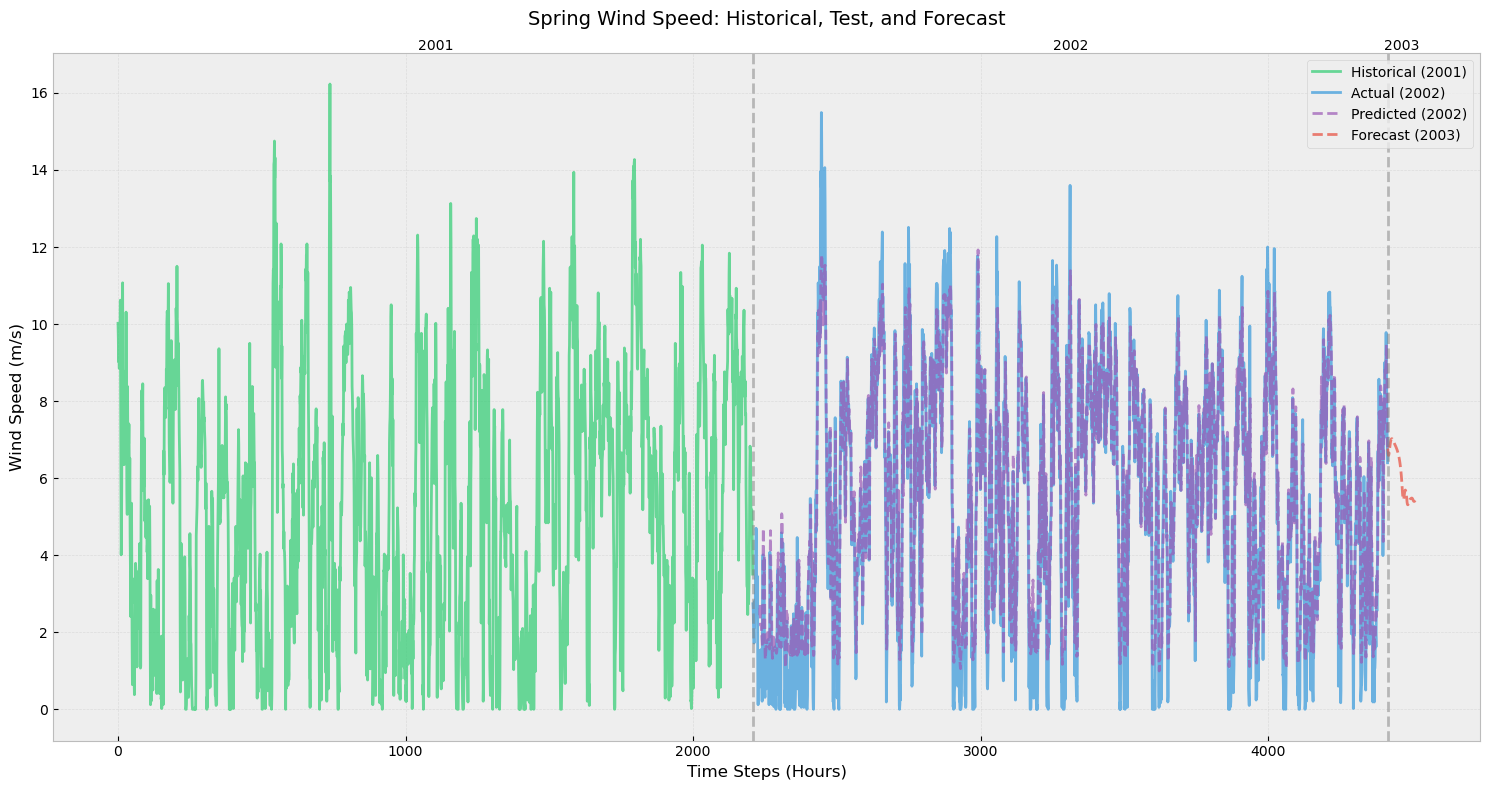


Spring Performance Metrics:
2002 Test Set Metrics:
MAE: 0.93
RMSE: 1.21
MAPE: inf%

Wind Speed Statistics:
2001 Mean: 5.23 m/s
2002 Mean: 5.35 m/s
2003 Forecast Mean: 6.11 m/s
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


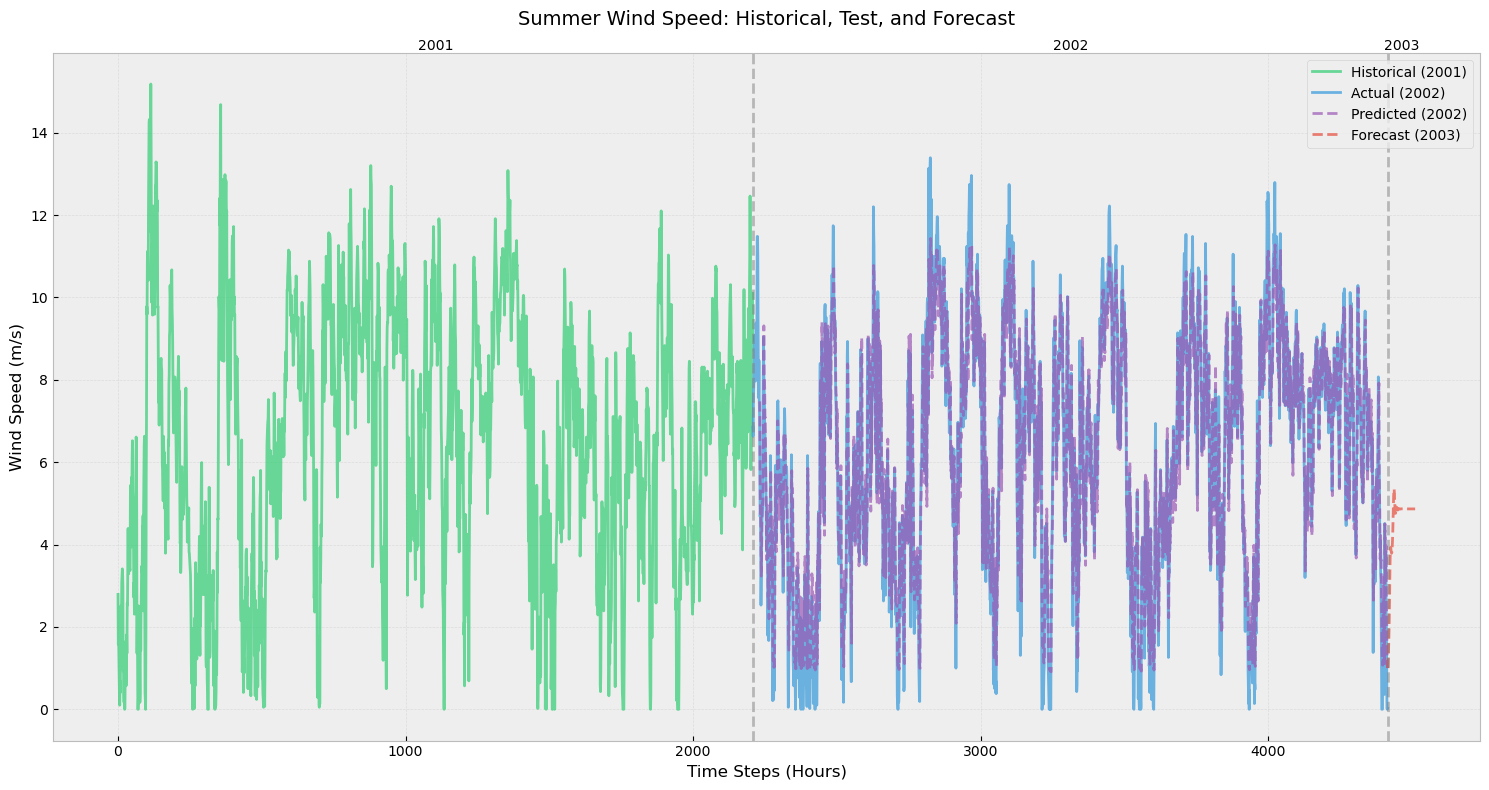


Summer Performance Metrics:
2002 Test Set Metrics:
MAE: 0.80
RMSE: 1.04
MAPE: inf%

Wind Speed Statistics:
2001 Mean: 6.53 m/s
2002 Mean: 6.23 m/s
2003 Forecast Mean: 4.53 m/s
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


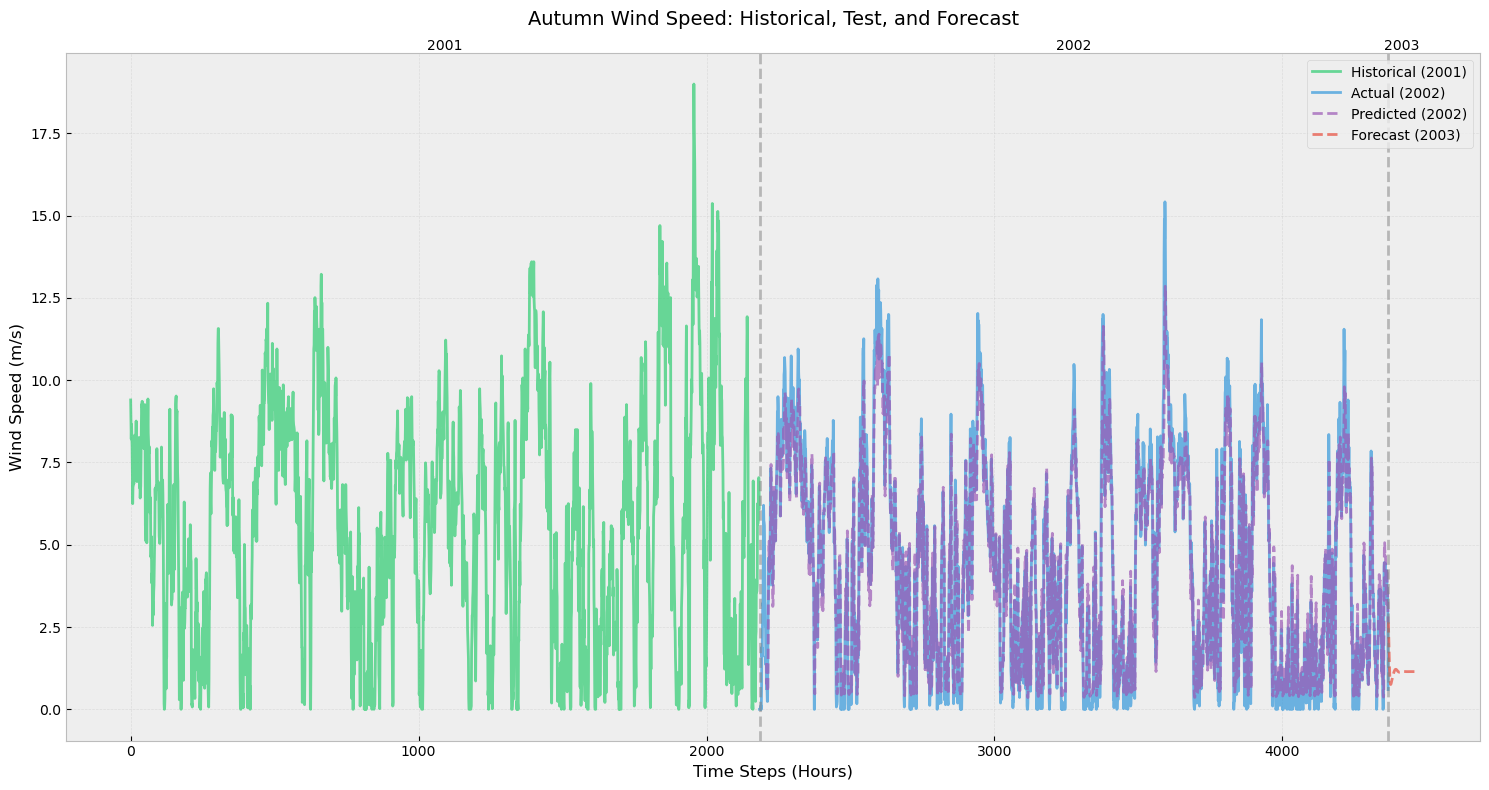


Autumn Performance Metrics:
2002 Test Set Metrics:
MAE: 0.79
RMSE: 1.08
MAPE: inf%

Wind Speed Statistics:
2001 Mean: 5.70 m/s
2002 Mean: 4.39 m/s
2003 Forecast Mean: 1.16 m/s
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


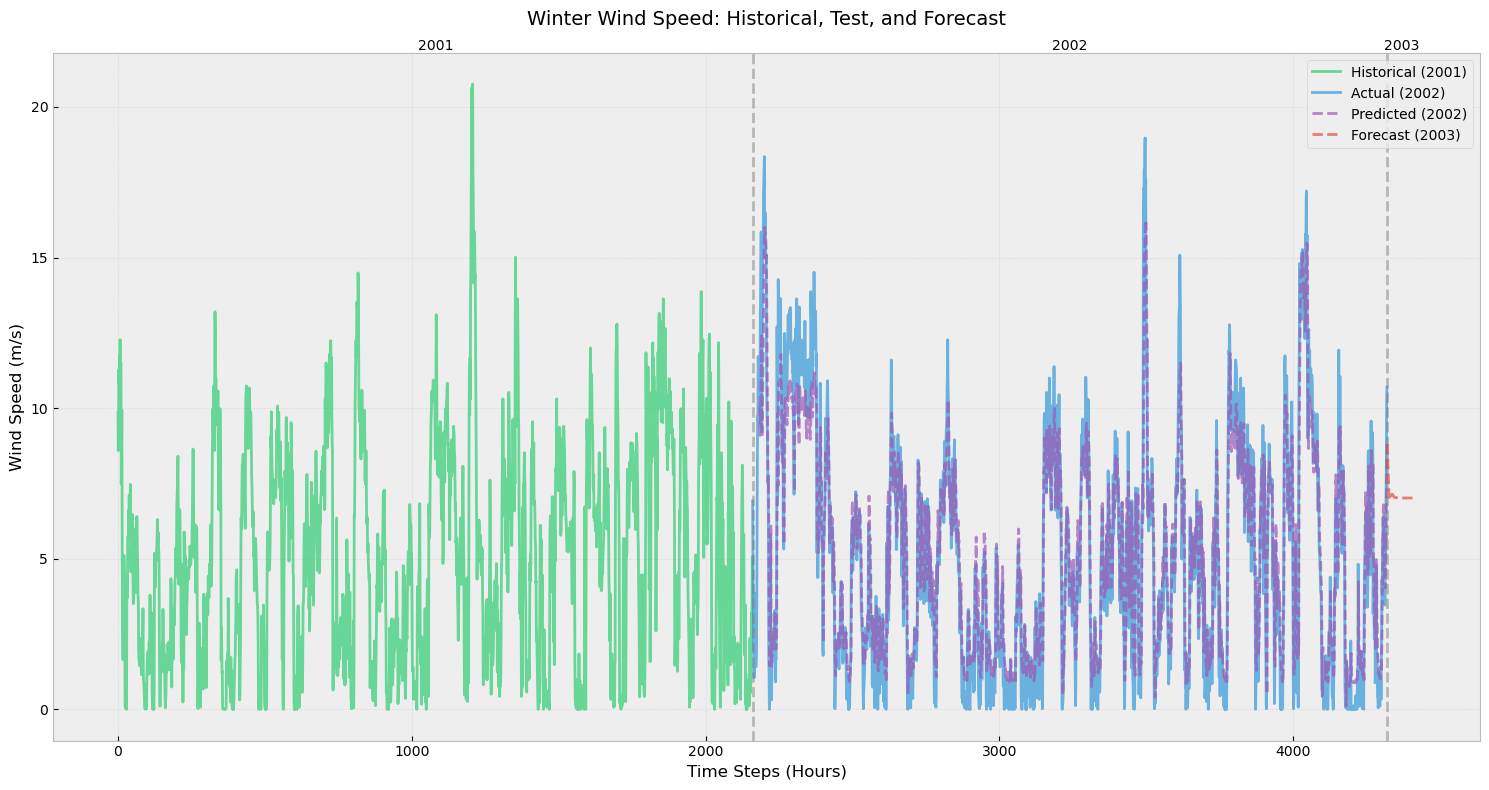


Winter Performance Metrics:
2002 Test Set Metrics:
MAE: 1.05
RMSE: 1.38
MAPE: inf%

Wind Speed Statistics:
2001 Mean: 5.03 m/s
2002 Mean: 5.09 m/s
2003 Forecast Mean: 7.10 m/s


In [13]:
"""# Comprehensive Seasonal Visualizations"""

# Set style for better visualizations
plt.style.use('bmh')  # Using 'bmh' style instead of seaborn
colors = {
    'historical': '#2ecc71',  # green
    'test': '#3498db',       # blue
    'forecast': '#e74c3c',   # red
    'predicted': '#9b59b6'   # purple
}

# Create visualization for each season
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    plt.figure(figsize=(15, 8))
    
    # Plot historical data (2001)
    historical_data = seasonal_dfs[season][seasonal_dfs[season].index.year == 2001]['Wind (m/s 10 m)']
    plt.plot(range(len(historical_data)), 
            historical_data, 
            label='Historical (2001)', 
            color=colors['historical'], 
            alpha=0.7)
    
    # Plot test data (2002)
    test_data = seasonal_dfs[season][seasonal_dfs[season].index.year == 2002]['Wind (m/s 10 m)']
    plt.plot(range(len(historical_data), len(historical_data) + len(test_data)), 
            test_data, 
            label='Actual (2002)', 
            color=colors['test'], 
            alpha=0.7)
    
    # Plot test predictions
    _, _, X_val, y_val, _ = prepare_seasonal_data(seasonal_dfs[season])
    test_pred = models[season].predict(X_val)
    test_pred = scalers[season].inverse_transform(test_pred)
    plt.plot(range(len(historical_data) + 24, len(historical_data) + len(test_data)), 
            test_pred, 
            label='Predicted (2002)', 
            color=colors['predicted'], 
            linestyle='--', 
            alpha=0.7)
    
    # Plot 2003 forecasts
    forecast = forecasts_2003[season]
    plt.plot(range(len(historical_data) + len(test_data), 
                  len(historical_data) + len(test_data) + len(forecast)), 
            forecast, 
            label='Forecast (2003)', 
            color=colors['forecast'], 
            linestyle='--', 
            alpha=0.7)
    
    # Customize plot
    plt.title(f'{season} Wind Speed: Historical, Test, and Forecast', fontsize=14, pad=20)
    plt.xlabel('Time Steps (Hours)', fontsize=12)
    plt.ylabel('Wind Speed (m/s)', fontsize=12)
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Add vertical lines to separate years
    plt.axvline(x=len(historical_data), color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=len(historical_data) + len(test_data), color='gray', linestyle='--', alpha=0.5)
    
    # Add year labels
    plt.text(len(historical_data)/2, plt.ylim()[1], '2001', 
             horizontalalignment='center', verticalalignment='bottom')
    plt.text(len(historical_data) + len(test_data)/2, plt.ylim()[1], '2002', 
             horizontalalignment='center', verticalalignment='bottom')
    plt.text(len(historical_data) + len(test_data) + len(forecast)/2, plt.ylim()[1], '2003', 
             horizontalalignment='center', verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print performance metrics for each period
    print(f"\n{season} Performance Metrics:")
    print("=" * 50)
    
    # Test set (2002) metrics
    test_mae = mean_absolute_error(test_data[24:], test_pred)
    test_rmse = np.sqrt(mean_squared_error(test_data[24:], test_pred))
    test_mape = np.mean(np.abs((test_data[24:] - test_pred.flatten()) / test_data[24:])) * 100
    
    print(f"2002 Test Set Metrics:")
    print(f"MAE: {test_mae:.2f}")
    print(f"RMSE: {test_rmse:.2f}")
    print(f"MAPE: {test_mape:.2f}%")
    
    # Basic statistics
    print(f"\nWind Speed Statistics:")
    print(f"2001 Mean: {historical_data.mean():.2f} m/s")
    print(f"2002 Mean: {test_data.mean():.2f} m/s")
    print(f"2003 Forecast Mean: {forecast.mean():.2f} m/s")
    print("=" * 50)